In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import matplotlib.pyplot as plt

In [2]:
''' With this for loop we are filtering images that not feature the string "JFIF", so we are removing them to keep only images
that fit the feature string '''
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
'''
Now we are generating our dataset, as parameters we set the hight/width of image to be 180, because of RGB the image will be
represented by a column that contains 180 * 180 * 3 features
'''
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


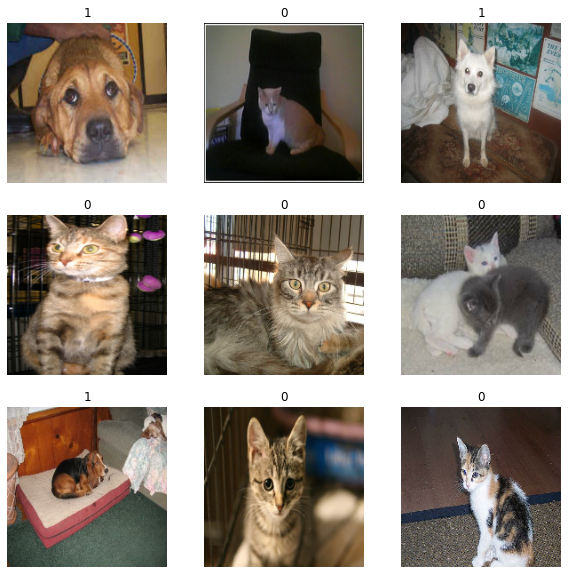

In [4]:
''' using the famous visualisation library matplotlib, we are here Visualizing some exemples in our dataset'''
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
'''
because our data is not big, and for training our model we need huge number of images to give us good results, there is a technique
called data augmentation so we will try to apply that to our dataset.
What data augmentation do is random horizontal flipping or small random rotations.
'''
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

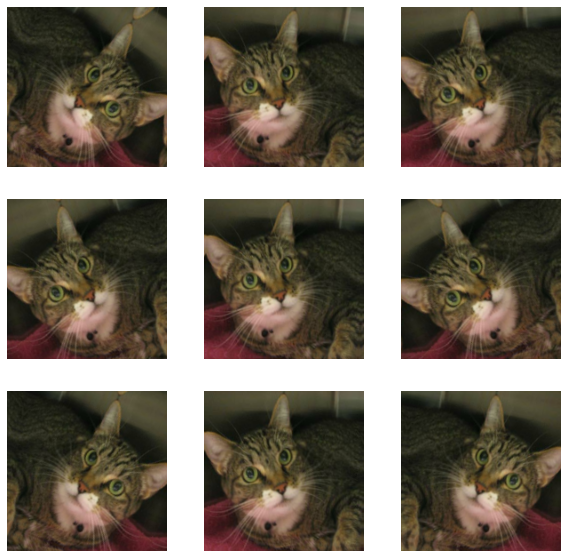

In [6]:
'''
by applying data augmentation to the first exemples in our dataset, we will visualize what the augmented samples look like.
as i said before it a random horizontal flipping or small random rotations.
'''
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
'''
Now we will use lambda function to simply apply data augmentation to all training images.
'''
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

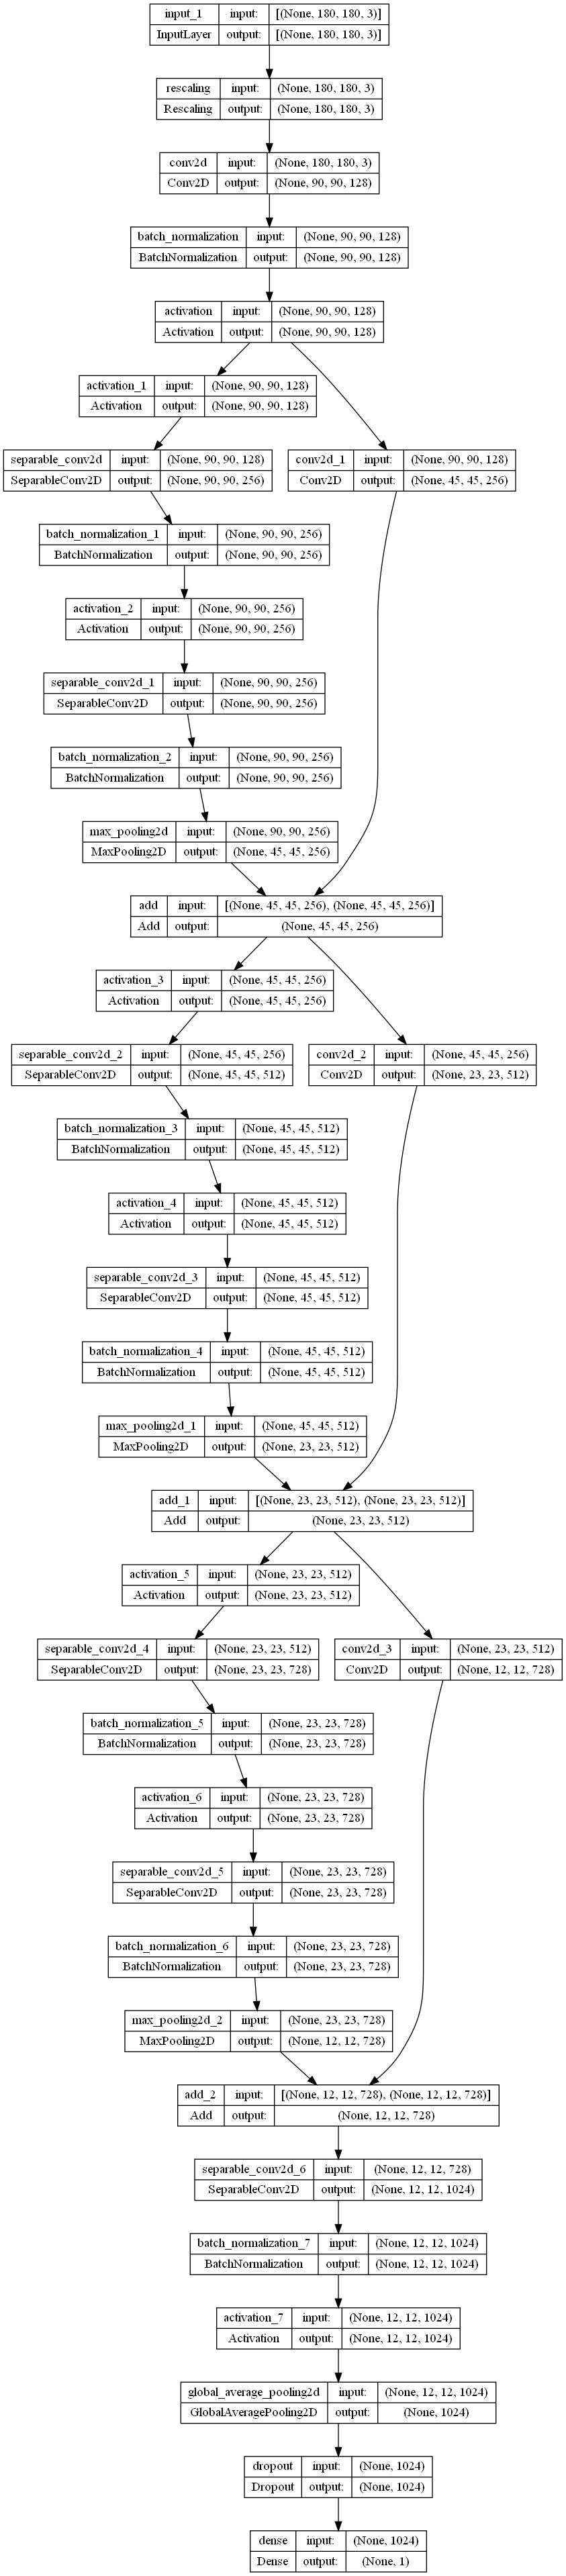

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
#Here we are using a rescaling layer for data standarization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    #Setting ReLu function as an activation function
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    
# Now we will create a for loop to apply all previous steps for each value in [256,512,728]
    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
# Here we will add the new x value and the previous residual to the layer
        x = layers.add([x, residual])  # Add back residual
#Here we will update the previous block activation with the new one calculated in the for loop
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

#If the number of class equal to 2 then the activation function must be sigmoid, because it gives us values between [0,1] 
#if not we will go for softmax or tanh activation functions
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# The last step is fitting the model
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3), # For the optimizer we choose adam instead of gradient descent
    loss="binary_crossentropy", # we choose the binary crossentropy form to calcul the loss function
    metrics=["accuracy"], #and the accuracy to evaluate the prefromances of our model.
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

In [ ]:
#Here we will run the model on new data that he has never seen and he will give us percentage of being a cat or dog.
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")